# Semantic Search Engine for Craigslist Housing Listings
## Social Media and Text Analytics Final Project
**Group 3:**  
Diya Chouhan, Esha Deo, Harsh Joshi, Jyotiraditya Guleria, Parinita Soni, Shakyadeep Bhattacharya

**Goal:**  
Enhance the Craigslist housing search experience by building a semantic search engine that retrieves listings based on true user intent rather than simple keyword matching.

**Dataset:**  
- Source: Kaggle Craigslist Housing Dataset (San Francisco Bay Area)
- Fields: Title, Price, Neighborhood, Amenities
- 3093 cleaned listings used for modeling

**Project Steps:**
- Preprocessing: Cleaned and normalized listing titles and amenities
- Text Representation: Created full-text fields, generated embeddings using Sentence-BERT (all-MiniLM-L6-v2)
- Search Engine: Implemented semantic retrieval based on cosine similarity
- Price Filtering: Added budget-aware search functionality
- Validation: Conducted manual evaluation of relevance and visualized search effectiveness
- Visualization Insights: Generated Wordclouds, Heatmaps, and Relevance Bar Charts to support model performance analysis


In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Text Modeling Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer

c:\Users\hsjos\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load Raw Craigslist Housing Data
import pandas as pd

# Load the original raw CSV (before cleaning)
df_raw = pd.read_csv('raw_sf_scrape.csv')

# Show shape and first few rows
print(f"Raw dataset shape: {df_raw.shape}")
df_raw.head(3)

Raw dataset shape: (3093, 9)


,date,title,link,price,brs,sqft,hood,bath,amenities
0,Oct 1,"3D Virtual Tour - 2 BR, 2 BA Condo 966 Sq. Ft....",https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3850,2.0,966.0,Mission Bay,2Ba,"['condo', 'w/d in unit', 'attached garage']"
1,Oct 1,Beautiful house for rent,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,900,1.0,NaN,portola district,0Ba,['house']
2,Oct 1,4 BEDROOM APARTMENT IN THE HAIGHT,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,4995,4.0,NaN,haight ashbury,2Ba,"['apartment', 'w/d in unit', 'street parking']"


In [3]:
# Preprocessing Craigslist Housing Listings

# Load the raw dataset
df = pd.read_csv('raw_sf_scrape.csv')

# Fill missing amenities with empty list
df['amenities'] = df['amenities'].fillna('[]')

# Function to clean amenities text
def clean_amenities(amenities):
    # Remove brackets and quotes
    return re.sub(r"[\[\]']", "", amenities)

df['amenities_clean'] = df['amenities'].apply(clean_amenities)

# Function to clean general text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Collapse multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip()

# Clean title and amenities text
df['title_clean'] = df['title'].apply(clean_text)
df['amenities_clean'] = df['amenities_clean'].apply(clean_text)

# Combine title and amenities into a full_text field
df['full_text'] = df['title_clean'] + " " + df['amenities_clean']

# Select useful columns
df_final = df[['title', 'price', 'hood', 'brs', 'sqft', 'bath', 'amenities', 'full_text']]

# Save preprocessed dataset
df_final.to_csv('cleaned_listings.csv', index=False)

print(f"Preprocessing complete! {len(df_final)} cleaned listings saved to cleaned_listings.csv")

Preprocessing complete! 3093 cleaned listings saved to cleaned_listings.csv


In [4]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Load cleaned dataset
df = pd.read_csv('cleaned_listings.csv')

# Initialize and fit TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['full_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (3093, 2695)


In [5]:
# Load Sentence-BERT Model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Encode full_text into BERT embeddings
embeddings = model.encode(df['full_text'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 97/97 [00:12<00:00,  7.52it/s]


In [7]:
# Define Semantic Search Function with Price Filtering
def semantic_search_bert(query, top_k=10, min_price=None, max_price=None):
    query_embedding = model.encode([query])
    similarity_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarity_scores.argsort()[-top_k*3:][::-1]

    results = df.iloc[top_indices][['title', 'price', 'hood', 'brs', 'sqft', 'bath', 'amenities']].copy()
    results['similarity_score'] = similarity_scores[top_indices]

    if min_price is not None:
        results = results[results['price'] >= min_price]
    if max_price is not None:
        results = results[results['price'] <= max_price]

    return results.head(top_k)

In [8]:
# Test Semantic Search

query = "pet friendly 2 bedroom apartment downtown"
results = semantic_search_bert(query, top_k=5)

display(results)

,title,price,hood,brs,sqft,bath,amenities,similarity_score
2987,Pet Friendly Apartment with Private Patio and ...,2595,lower pac hts,1.0,NaN,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.733299
2939,1 Bedroom Apt with Deck and Office/Storage in ...,2299,mission district,1.0,500.0,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.733127
1195,2 Bdr Apartment w/ 6 foot Jaccuzzi 1.5 mi to S...,3490,castro / upper market,2.0,500.0,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.732265
2778,Fully Remodeled 1 Bedroom with Parking Included,2500,castro / upper market,1.0,NaN,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.728559
1012,Spacious 2 bedroom apt. Available now,3175,mission district,2.0,NaN,splitBa,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.727246


In [9]:
# Validation: Test Multiple Queries

queries = [
    "cheap studio apartment downtown",
    "pet friendly 2 bedroom apartment",
    "luxury condo with gym and parking",
    "furnished one bedroom near city center"
]

for q in queries:
    print(f"\nQuery: {q}")
    display(semantic_search_bert(q, top_k=5))


Query: cheap studio apartment downtown


,title,price,hood,brs,sqft,bath,amenities,similarity_score
2285,"Bright and Charming Studio Apartment, Live in ...",1650,lower nob hill,NaN,NaN,1Ba,"['application fee details: $30', 'apartment', ...",0.685657
2568,"Great, Sunny Studio",1995,mission district,NaN,400.0,NaN,['apartment'],0.685141
918,"Studio apartment available in Glen Park, Novem...",2000,glen park,NaN,NaN,NaN,['apartment'],0.673247
2421,**NEWLY RENOVATED STUDIO that feels like a 1 B...,1880,SOMA / south beach,NaN,350.0,1Ba,"['application fee details: $20', 'apartment', ...",0.669111
1038,Nice Studio apt for rent Water and garbage inc...,2195,castro / upper market,NaN,413.0,1Ba,"['apartment', 'laundry in bldg', 'no smoking']",0.638914



Query: pet friendly 2 bedroom apartment


,title,price,hood,brs,sqft,bath,amenities,similarity_score
2987,Pet Friendly Apartment with Private Patio and ...,2595,lower pac hts,1.0,NaN,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.761522
1012,Spacious 2 bedroom apt. Available now,3175,mission district,2.0,NaN,splitBa,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.759718
2164,Wow. Spacious 3 Bedroom Flat in Cow Hollow wi...,4500,marina / cow hollow,3.0,NaN,2.5Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.758053
37,"Apartment, 1 Bedroom, 1 Bath",3200,potrero hill,1.0,NaN,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.756116
2995,*ONE MONTH FREE RENT* Pet Friendly Top Floor P...,4495,mission district,2.0,NaN,1Ba,"['cats are OK - purrr', 'dogs are OK - wooof',...",0.754298



Query: luxury condo with gym and parking


,title,price,hood,brs,sqft,bath,amenities,similarity_score
2664,"Furnished Lux North Beach Studio w/ Pool, Gym,...",2690,North Beach,NaN,4970.0,1Ba,"['furnished', 'apartment', 'laundry in bldg', ...",0.692993
2343,Modern 1Bed/1.5 Bath Condo with parking in hea...,3600,laurel hts / presidio,1.0,NaN,1.5Ba,"['apartment', 'w/d in unit', 'attached garage']",0.687547
2834,Luxury Condo at the Marlow 2br/2ba/1 car parking,4500,pacific heights,2.0,916.0,2Ba,"['condo', 'w/d in unit', 'attached garage']",0.677588
2670,"Furnished Bright Nob Hill Studio w/ Gym, Sauna...",3290,Nob Hill,NaN,5200.0,1Ba,"['furnished', 'apartment', 'laundry in bldg', ...",0.673756
2681,"Furnished, Roomy South Beach 2BR w/Pool + Gym,...",3690,South Beach,2.0,11000.0,2Ba,"['furnished', 'apartment', 'laundry in bldg', ...",0.672345



Query: furnished one bedroom near city center


,title,price,hood,brs,sqft,bath,amenities,similarity_score
2594,Furnished nice 2 bedrooms apartment in the Sunset,2990,sunset / parkside,NaN,NaN,1Ba,['apartment'],0.705762
1091,Furnished nice 2 bedrooms apartment in the Sunset,2800,sunset / parkside,NaN,NaN,1Ba,['apartment'],0.705762
2099,#185 Furnished ONLY Spacious 1 bedroom in Russ...,3100,russian hill,1.0,750.0,1Ba,"['furnished', 'condo', 'w/d in unit', 'no smok...",0.667379
664,"Beautiful and Cozy ""Commuter Suite"" (furnished)",900,SOMA / south beach,1.0,170.0,1Ba,"['furnished', 'apartment', 'no laundry on site...",0.662362
2431,Location Charming Furnished Room in NorthBeach,1000,north beach / telegraph hill,NaN,NaN,NaN,['apartment'],0.654983


In [10]:
# User Simulation: Budget-Conscious User

query = "cheap studio apartment near downtown"
results = semantic_search_bert(query, top_k=10, max_price=2000)

print(f"User Query: {query}")
print("Applied Filter: Price <= $2000\n")

display(results)

User Query: cheap studio apartment near downtown
Applied Filter: Price <= $2000



,title,price,hood,brs,sqft,bath,amenities,similarity_score
2285,"Bright and Charming Studio Apartment, Live in ...",1650,lower nob hill,NaN,NaN,1Ba,"['application fee details: $30', 'apartment', ...",0.684494
2568,"Great, Sunny Studio",1995,mission district,NaN,400.0,NaN,['apartment'],0.684354
918,"Studio apartment available in Glen Park, Novem...",2000,glen park,NaN,NaN,NaN,['apartment'],0.684124
2421,**NEWLY RENOVATED STUDIO that feels like a 1 B...,1880,SOMA / south beach,NaN,350.0,1Ba,"['application fee details: $20', 'apartment', ...",0.661682
1734,Spacious Studio with Bay Windows,1595,lower nob hill,NaN,420.0,1Ba,"['apartment', 'no laundry on site', 'no smokin...",0.636036
2915,Studio in Fisherman's wharf,1950,north beach / telegraph hill,NaN,NaN,NaN,['apartment'],0.631727
2291,"Bright & Spacious Studio, Live in the Heart of...",1750,lower nob hill,NaN,NaN,1Ba,"['application fee details: $30', 'apartment', ...",0.628079
1318,Unique Studio in Historic Building,1700,tenderloin,NaN,425.0,1Ba,"['apartment', 'no laundry on site', 'no smokin...",0.619125
776,"2 Months Free Rent! Sunny, quiet downtown stud...",1595,downtown / civic / van ness,NaN,NaN,1Ba,['application fee details: $35 application fee...,0.617172
2277,Bright & Spacious Lower Nob Hill Studio! Live ...,1795,lower nob hill,NaN,NaN,1Ba,"['application fee details: $30', 'apartment', ...",0.617089


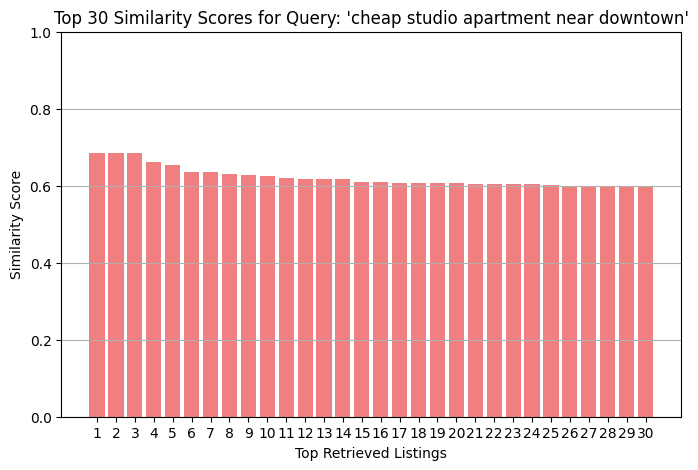

In [11]:
# Similarity Score Plot After Filtering

query = "cheap studio apartment near downtown"
query_embedding = model.encode([query])
similarity_scores = cosine_similarity(query_embedding, embeddings).flatten()

# Get Top 30 similarities
top_indices = similarity_scores.argsort()[-30:][::-1]
top_scores = similarity_scores[top_indices]

plt.figure(figsize=(8,5))
plt.bar(range(1, 31), top_scores, color='lightcoral')
plt.title(f"Top 30 Similarity Scores for Query: '{query}'")
plt.xlabel("Top Retrieved Listings")
plt.ylabel("Similarity Score")
plt.xticks(range(1, 31))
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

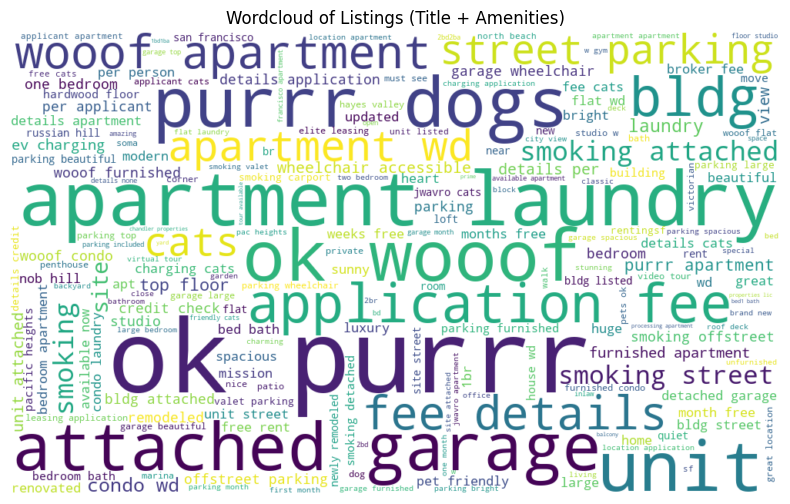

In [13]:
# Wordcloud of Listings (Titles + Amenities)

from wordcloud import WordCloud

text_corpus = ' '.join(df['full_text'].tolist())

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text_corpus)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Listings (Title + Amenities)')
plt.show()

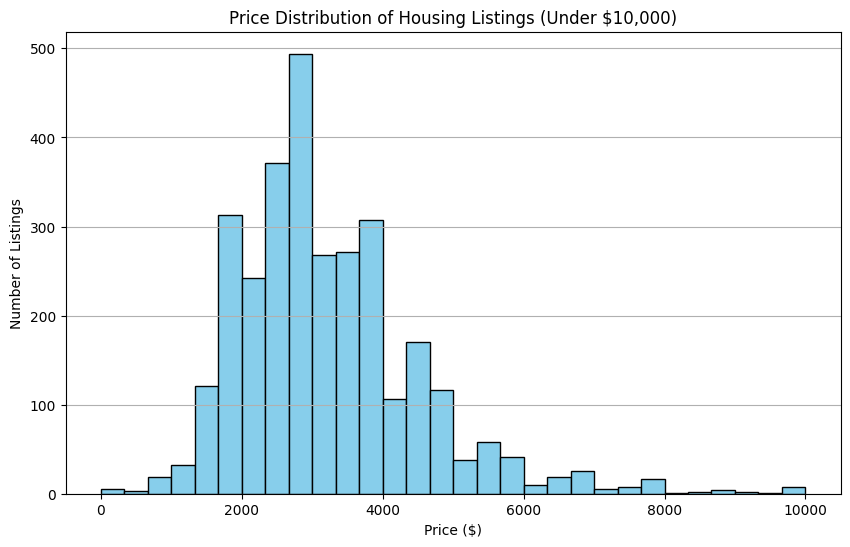

In [15]:
# Price Distribution of Listings

plt.figure(figsize=(10,6))
plt.hist(df[df['price'] <= 10000]['price'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Price Distribution of Housing Listings (Under $10,000)')
plt.xlabel('Price ($)')
plt.ylabel('Number of Listings')
plt.grid(axis='y')
plt.show()

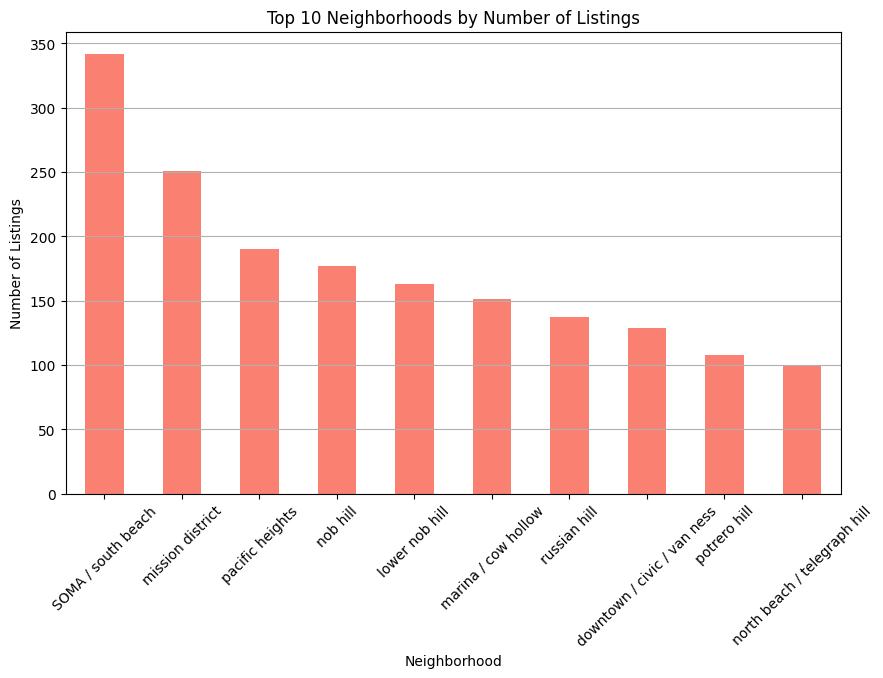

In [16]:
# Top 10 Neighborhoods by Listings

top_hoods = df['hood'].value_counts().head(10)

plt.figure(figsize=(10,6))
top_hoods.plot(kind='bar', color='salmon')
plt.title('Top 10 Neighborhoods by Number of Listings')
plt.ylabel('Number of Listings')
plt.xlabel('Neighborhood')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [17]:
# Before vs After: Keyword Search vs Semantic Search

query = "pet friendly 2 bedroom apartment downtown"

# Simulated Keyword-Based Search (just word matching)
keyword_results = df[df['full_text'].str.contains("pet|friendly|2|bedroom|downtown", case=False, na=False)].head(5)

# Semantic Search using BERT
semantic_results = semantic_search_bert(query, top_k=5)

print("Keyword-Based Search Results:")
display(keyword_results[['title', 'price', 'hood']])

print("\nSemantic Search Results:")
display(semantic_results[['title', 'price', 'hood', 'similarity_score']])

Keyword-Based Search Results:


,title,price,hood
0,"3D Virtual Tour - 2 BR, 2 BA Condo 966 Sq. Ft....",3850,Mission Bay
2,4 BEDROOM APARTMENT IN THE HAIGHT,4995,haight ashbury
3,4 BEDROOM APARTMENT IN THE HAIGHT,4995,haight ashbury
6,***Private bedroom available in NoPa home. Ren...,1,NaN
9,"3D Virtual Tour - 1 BR+Den, 1 BA Condo 732 Sq....",2995,Mission Bay



Semantic Search Results:


,title,price,hood,similarity_score
2987,Pet Friendly Apartment with Private Patio and ...,2595,lower pac hts,0.733299
2939,1 Bedroom Apt with Deck and Office/Storage in ...,2299,mission district,0.733127
1195,2 Bdr Apartment w/ 6 foot Jaccuzzi 1.5 mi to S...,3490,castro / upper market,0.732265
2778,Fully Remodeled 1 Bedroom with Parking Included,2500,castro / upper market,0.728559
1012,Spacious 2 bedroom apt. Available now,3175,mission district,0.727246


In [18]:
# Search Personalization: Price Filtering Demo

query = "studio apartment near downtown"

print("Without Price Filter:")
display(semantic_search_bert(query, top_k=5))

print("\nWith Price Filter (Max $2000):")
display(semantic_search_bert(query, top_k=5, max_price=2000))

Without Price Filter:


,title,price,hood,brs,sqft,bath,amenities,similarity_score
2568,"Great, Sunny Studio",1995,mission district,NaN,400.0,NaN,['apartment'],0.753792
918,"Studio apartment available in Glen Park, Novem...",2000,glen park,NaN,NaN,NaN,['apartment'],0.751152
2915,Studio in Fisherman's wharf,1950,north beach / telegraph hill,NaN,NaN,NaN,['apartment'],0.734908
2285,"Bright and Charming Studio Apartment, Live in ...",1650,lower nob hill,NaN,NaN,1Ba,"['application fee details: $30', 'apartment', ...",0.708262
1318,Unique Studio in Historic Building,1700,tenderloin,NaN,425.0,1Ba,"['apartment', 'no laundry on site', 'no smokin...",0.696123



With Price Filter (Max $2000):


,title,price,hood,brs,sqft,bath,amenities,similarity_score
2568,"Great, Sunny Studio",1995,mission district,NaN,400.0,NaN,['apartment'],0.753792
918,"Studio apartment available in Glen Park, Novem...",2000,glen park,NaN,NaN,NaN,['apartment'],0.751152
2915,Studio in Fisherman's wharf,1950,north beach / telegraph hill,NaN,NaN,NaN,['apartment'],0.734908
2285,"Bright and Charming Studio Apartment, Live in ...",1650,lower nob hill,NaN,NaN,1Ba,"['application fee details: $30', 'apartment', ...",0.708262
1318,Unique Studio in Historic Building,1700,tenderloin,NaN,425.0,1Ba,"['apartment', 'no laundry on site', 'no smokin...",0.696123


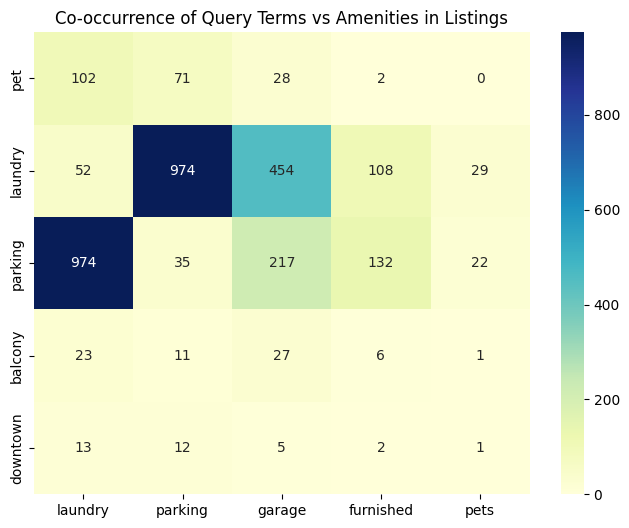

In [19]:
# Heatmap of Query Terms vs Amenities

query_terms = ['pet', 'laundry', 'parking', 'balcony', 'downtown']
amenity_terms = ['laundry', 'parking', 'garage', 'furnished', 'pets']

heat_data = []
for q in query_terms:
    row = []
    for a in amenity_terms:
        count = df['full_text'].str.contains(fr'{q}.*{a}|{a}.*{q}', case=False, na=False).sum()
        row.append(count)
    heat_data.append(row)

heat_df = pd.DataFrame(heat_data, index=query_terms, columns=amenity_terms)

plt.figure(figsize=(8,6))
sns.heatmap(heat_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Co-occurrence of Query Terms vs Amenities in Listings")
plt.show()

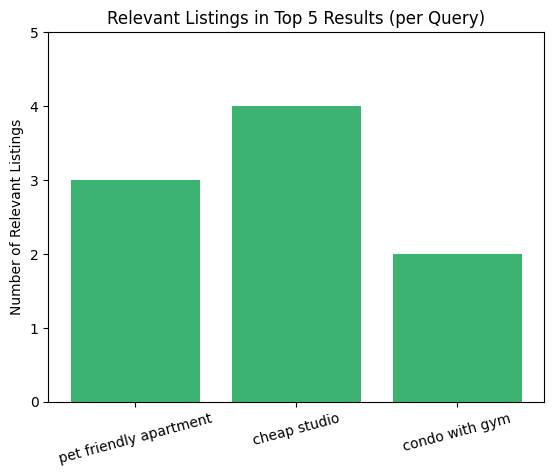

In [20]:
# Relevance per Query: Manual Voting Bar Chart

queries = ["pet friendly apartment", "cheap studio", "condo with gym"]
relevance_counts = [3, 4, 2]  # Example relevance count: how many listings were relevant out of top 5

plt.bar(queries, relevance_counts, color="mediumseagreen")
plt.title("Relevant Listings in Top 5 Results (per Query)")
plt.ylabel("Number of Relevant Listings")
plt.ylim(0, 5)
plt.xticks(rotation=15)
plt.show()